## Introduction

Many U.S. cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

Hadi Fanaee-T at the University of Porto compiled this data into a CSV file, which you'll work with in this project. The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. You can download the data from the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset). 

In this project, we'll try to predict the total number of bikes people rented in a given hour.

## Initial Explorations

Here are the descriptions for the relevant columns:

* instant - A unique sequential ID number for each row
* dteday - The date of the rentals
* season - The season in which the rentals occurred
* yr - The year the rentals occurred
* mnth - The month the rentals occurred
* hr - The hour the rentals occurred
* holiday - Whether or not the day was a holiday
* weekday - The day of the week (as a number, 0 to 7)
* workingday - Whether or not the day was a working day
* weathersit - The weather (as a categorical variable)
* temp - The temperature, on a 0-1 scale
* atemp - The adjusted temperature
* hum - The humidity, on a 0-1 scale
* windspeed - The wind speed, on a 0-1 scale
* casual - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
* registered - The number of registered riders (people who had already signed up)
* cnt - The total number of bike rentals (casual + registered)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
bike_rentals = pd.read_csv('bike_rental_hour.csv')
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
bike_rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


<AxesSubplot:>

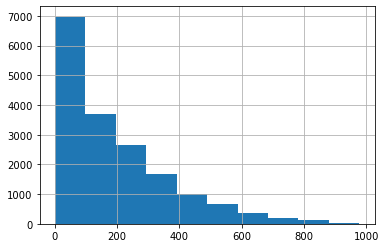

In [4]:
%matplotlib inline
# Make a histogram of the cnt column of bike_rentals
bike_rentals['cnt'].hist()

In [5]:
# explore how each column is correlated with cnt
bike_rentals.corr()['cnt']

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

In [6]:
# Write a function called assign_label to label the 'hr' column
def assign_label(hr):
    if 6 <= hr < 12:
        return 1
    elif 12 <= hr < 18:
        return 2
    elif 18 <= hr < 24:
        return 3
    elif 0 <= hr < 6:
        return 4
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)

The mean squared error metric makes the most sense to evaluate our error. MSE works on continuous numeric data, which fits our data.

In [7]:
# splitting our data into train and test portions
train = bike_rentals.sample(frac= .8)
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

In [8]:
features = list(train.columns)
drop_features = ['cnt', 'casual', 'dteday', 'registered']
for item in drop_features:
    features.remove(item)

## Linear Regression Model

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
lr = LinearRegression()
lr.fit(train[features], train['cnt'])
lr_predictions = lr.predict(test[features])
lr_mse = mean_squared_error(test['cnt'], lr_predictions)
lr_mse

17012.021715466068

Text(0, 0.5, 'Predictions')

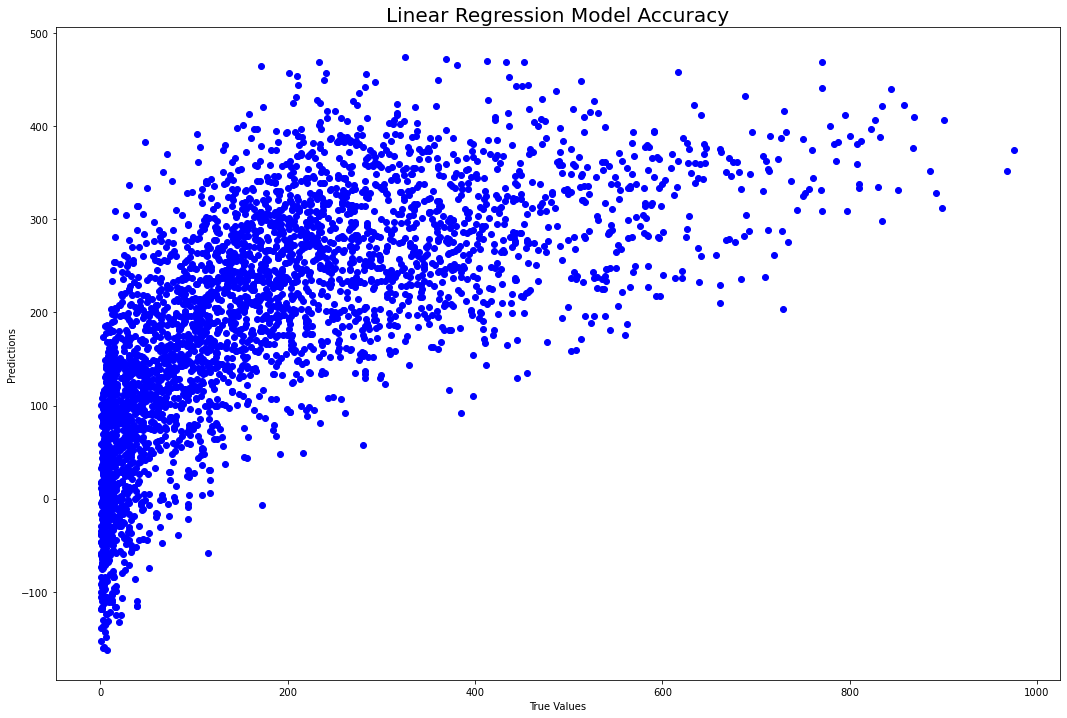

In [22]:
plt.figure(figsize=(18,12))
plt.scatter(test['cnt'], lr_predictions, c='b')
plt.title('Linear Regression Model Accuracy', fontsize = 20)
plt.xlabel('True Values')
plt.ylabel('Predictions')

The error is very high, which may be due to the fact that the data has a few extremely high rental counts, but otherwise mostly low counts. Larger errors are penalized more with MSE, which leads to a higher total error.

linear regression works best when predictors are linearly correlated to the target and also independent -- in other words, they don't change meaning when we combine them with each other. The good thing about linear regression is that it's fairly resistant to overfitting because it's straightforward. It also can be prone to underfitting the data, however, and not building a powerful enough model. This means that linear regression usually isn't the most accurate option.

## Decision Tree Model

In [26]:
from sklearn.tree import DecisionTreeRegressor
# Building Decision Tree model with default min_sample_leaf
dtr = DecisionTreeRegressor()
dtr.fit(train[features], train['cnt'])
dtr_predictions = dtr.predict(test[features])
dtr_mse= mean_squared_error(test['cnt'], dtr_predictions)
dtr_mse

2862.1199654775605

In [27]:
# Building Decision Tree model with min_sample_leaf = 10
dtr1 = DecisionTreeRegressor(min_samples_leaf=10)
dtr1.fit(train[features], train['cnt'])
dtr1_predictions = dtr1.predict(test[features])
dtr1_mse= mean_squared_error(test['cnt'], dtr1_predictions)
dtr1_mse

2499.5743420315275

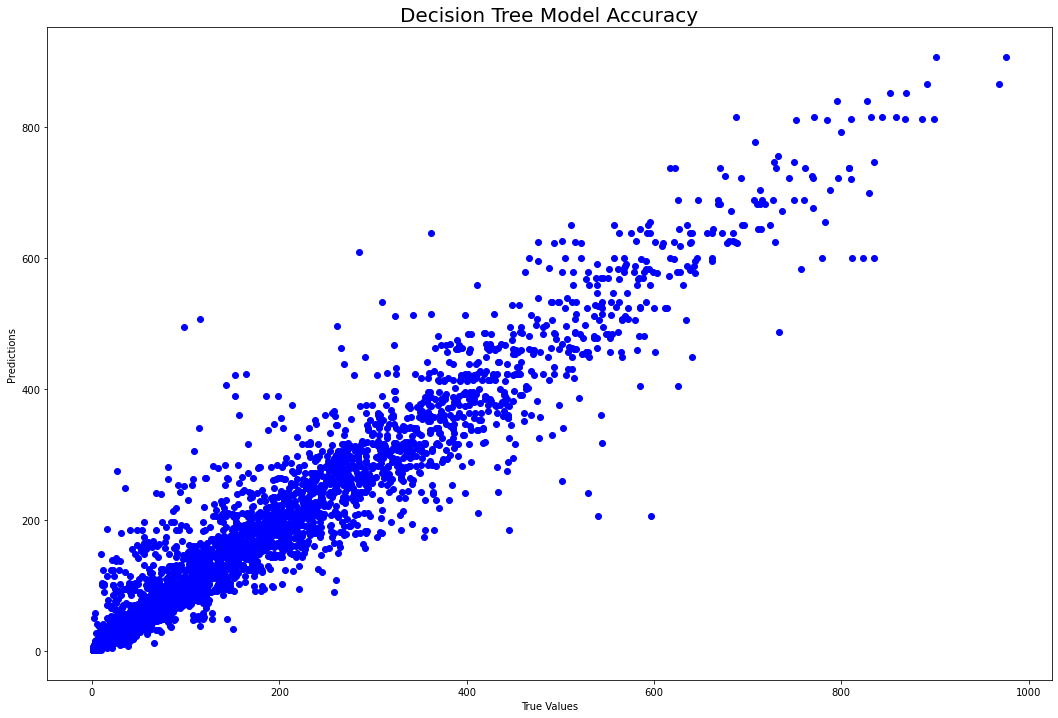

In [31]:
plt.figure(figsize=(18,12))
plt.scatter(test['cnt'], dtr1_predictions, c='b')
plt.title('Decision Tree Model Accuracy', fontsize = 20)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

By taking the nonlinear predictors into account, the decision tree regressor appears to have much higher accuracy than linear regression.

## Random Forrest Model

In [33]:
from sklearn.ensemble import RandomForestRegressor
# Building Decision Tree model with min_sample_leaf = 10
rfr = RandomForestRegressor(min_samples_leaf=10)
rfr.fit(train[features], train['cnt'])
rfr_predictions = rfr.predict(test[features])
rfr_mse= mean_squared_error(test['cnt'], rfr_predictions)
rfr_mse

2014.92622685759

In [32]:
# Building Decision Tree model with min_sample_leaf = 5
rfr = RandomForestRegressor(min_samples_leaf=5)
rfr.fit(train[features], train['cnt'])
rfr_predictions = rfr.predict(test[features])
rfr_mse= mean_squared_error(test['cnt'], rfr_predictions)
rfr_mse

1732.6140865625077

Text(0, 0.5, 'Predictions')

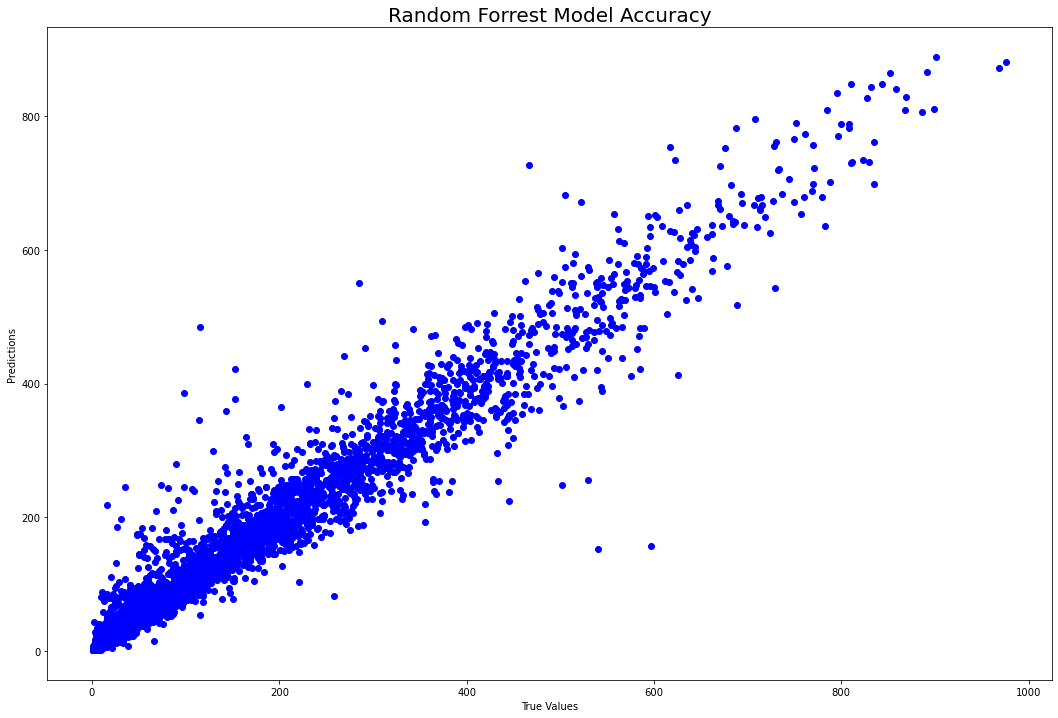

In [21]:
plt.figure(figsize=(18,12))
plt.scatter(test['cnt'], rfr_predictions, c='b')
plt.title('Random Forrest Model Accuracy', fontsize = 20)
plt.xlabel('True Values')
plt.ylabel('Predictions')

By removing some of the sources of overfitting, the random forest accuracy is improved over the decision tree accuracy.